In [1]:
from tensorflow.python.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM,GRU
 
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
 
from sklearn.preprocessing import MinMaxScaler
 
from datetime import datetime

from binance.client import Client

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
client = Client('', '')

In [3]:
klines = client.get_historical_klines("MATICUSDT", Client.KLINE_INTERVAL_2HOUR, "360 day ago UTC")

In [4]:
array = np.array(klines)

In [5]:
siz = np.size(array, 0)

In [6]:
df = pd.DataFrame.from_records(array)

In [7]:
df.columns = ['Open Time', 'Open', 
              'High', 'Low', 'Close', 
              'Volume', 'Close Time', 
              'Quote asset volume', 'Number of trades', 
              'Taken buy base asset volume', 'Taken buy quote asset volume', 
              'Can be ignored']

In [8]:
df.drop(['Close Time', 'Can be ignored'], axis=1, inplace=True)

In [9]:
df['Open Time'] = pd.to_numeric(df['Open Time'])/1000

In [10]:
df['Open'] = pd.to_numeric(df['Open'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])
df['Close'] = pd.to_numeric(df['Close'])
df['Volume'] = pd.to_numeric(df['Volume'])
df['Quote asset volume'] = pd.to_numeric(df['Quote asset volume'])
df['Number of trades'] = pd.to_numeric(df['Number of trades'])
df['Taken buy base asset volume'] = pd.to_numeric(df['Taken buy base asset volume'])
df['Taken buy quote asset volume'] = pd.to_numeric(df['Taken buy quote asset volume'])

In [11]:
df['Date'] = pd.to_datetime(df['Open Time'], unit='s').dt.date

In [12]:
group = df.groupby('Date') 

In [13]:
df.index = df['Date']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 2021-07-05 to 2022-06-30
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open Time                     4318 non-null   float64
 1   Open                          4318 non-null   float64
 2   High                          4318 non-null   float64
 3   Low                           4318 non-null   float64
 4   Close                         4318 non-null   float64
 5   Volume                        4318 non-null   float64
 6   Quote asset volume            4318 non-null   float64
 7   Number of trades              4318 non-null   int64  
 8   Taken buy base asset volume   4318 non-null   float64
 9   Taken buy quote asset volume  4318 non-null   float64
 10  Date                          4318 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 404.8+ KB


In [14]:
day_price = group['Close'].mean()

In [15]:
day_volume = group['Volume'].mean()

In [16]:
date1 = df['Date'][0]

In [17]:
date2 = df['Date'].iloc[-1]

In [18]:
delta = date2 - date1

days_look = delta.days + 1 

In [19]:
data_price = day_price[len(day_price) - days_look:len(day_price)]


In [20]:
scl_price = MinMaxScaler()

In [21]:
scl_volume = MinMaxScaler()

In [22]:
data_price = data_price.values.reshape(data_price.shape[0], 1)

In [23]:
data_volume = day_volume[len(day_volume) - days_look:len(day_volume)]

In [24]:
data_volume = data_volume.values.reshape(data_volume.shape[0], 1)

In [25]:
scale_data_price = scl_price.fit_transform(data_price)

In [26]:
scale_data_volume = scl_volume.fit_transform(data_volume)

In [27]:
SEQ_LEN = 50
WINDOW_SIZE = SEQ_LEN - 1
 
BATCH_SIZE=64
 
DROPOUT = 0.2

def load_data(data_raw_price, data_raw_volume, seq_len):
    
    data_price = []
    for index in range(len(data_raw_price) - seq_len):
        data_price.append(data_raw_price[index: index + seq_len])
    
    data_volume = []
    for index in range(len(data_raw_volume) - seq_len):
        data_volume.append(data_raw_volume[index: index + seq_len])
        
 
    data_price = np.array(data_price)
    data_volume = np.array(data_volume)
    
    train_split = 0.8
 
    num_data_price = data_price.shape[0]
    
    num_data_volume = data_volume.shape[0]

    
 
    num_train = int(train_split * num_data_price)
    
    print('Num Train')
    print(num_train)
    print('Num of Data')
    print(num_data_price)
    
 
    data_price = np.array(data_price)
    data_volume = np.array(data_volume)
 
    x_train_volume = data_volume[:num_train, :-1, :]
    y_train_price = data_price[:num_train, -1, :]
    
    x_test_volume = data_volume[num_train:, :-1, :]
    y_test_price = data_price[num_train:, -1, :]
    
    p_test_volume = data_volume[num_train:, -1, :]
    
    return [x_train_volume, y_train_price, x_test_volume, y_test_price, p_test_volume]

In [28]:
x_train_volume, y_train_price, x_test_volume, y_test_price, p_test_volume = load_data(scale_data_price, scale_data_volume, SEQ_LEN)

Num Train
248
Num of Data
311


In [29]:
model = Sequential()

In [30]:
bi = Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, x_train_volume.shape[-1]))

In [31]:
model.add(bi)

2022-06-30 23:12:37.593597: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 23:12:37.594142: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [32]:
model.add(Dropout(DROPOUT))

In [33]:
# Second Layer
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(DROPOUT))

In [34]:
# Third Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))

In [35]:
# Set activation function
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 49, 98)            19992     
_________________________________________________________________
dropout (Dropout)            (None, 49, 98)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense (Dense)                (None, 1)                 99        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

In [37]:
history = model.fit(x_train_volume, y_train_price, epochs=10, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test_volume, y_test_price),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


Train on 248 samples, validate on 63 samples
Epoch 1/10
248/248 [==============================] - 28s 114ms/sample - loss: 0.2432 - val_loss: 0.0197
Epoch 2/10
248/248 [==============================] - 10s 42ms/sample - loss: 0.0300 - val_loss: 0.3903
Epoch 3/10
248/248 [==============================] - 10s 41ms/sample - loss: 0.1640 - val_loss: 0.0807
Epoch 4/10
248/248 [==============================] - 10s 42ms/sample - loss: 0.0530 - val_loss: 0.0338
Epoch 5/10
248/248 [==============================] - 11s 44ms/sample - loss: 0.0648 - val_loss: 0.0366
Epoch 6/10
248/248 [==============================] - 11s 43ms/sample - loss: 0.0501 - val_loss: 0.0635
Epoch 7/10
248/248 [==============================] - 10s 42ms/sample - loss: 0.0273 - val_loss: 0.1197
Epoch 8/10
248/248 [==============================] - 10s 42ms/sample - loss: 0.0225 - val_loss: 0.1726
Epoch 9/10
248/248 [==============================] - 10s 42ms/sample - loss: 0.0311 - val_loss: 0.1641
Epoch 10/10
248/24

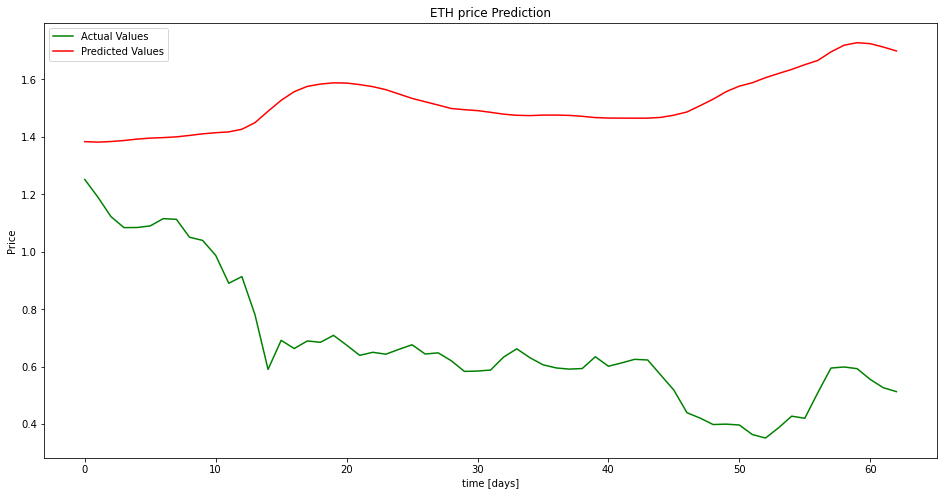

In [38]:
predict_prices = model.predict(x_test_volume)

plt.figure(figsize=(16,8))

plt.plot(scl_price.inverse_transform(y_test_price), label="Actual Values", color='green')
plt.plot(scl_price.inverse_transform(predict_prices), label="Predicted Values", color='red')


plt.title('ETH price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [39]:
predict_prices

array([[0.41713122],
       [0.41646487],
       [0.41729847],
       [0.4187359 ],
       [0.42073417],
       [0.4220844 ],
       [0.422822  ],
       [0.42388055],
       [0.42587712],
       [0.42812425],
       [0.4297049 ],
       [0.43085787],
       [0.43458408],
       [0.44382495],
       [0.45990843],
       [0.47529033],
       [0.4874974 ],
       [0.49491733],
       [0.49818358],
       [0.49990174],
       [0.49958298],
       [0.49743062],
       [0.49452627],
       [0.49026525],
       [0.48414457],
       [0.47805402],
       [0.47326005],
       [0.46861032],
       [0.46376944],
       [0.4621187 ],
       [0.4608184 ],
       [0.45842588],
       [0.4557789 ],
       [0.45423356],
       [0.4537924 ],
       [0.4545107 ],
       [0.45451415],
       [0.45410073],
       [0.45280376],
       [0.45100302],
       [0.45033783],
       [0.45023972],
       [0.45017004],
       [0.45018607],
       [0.45126835],
       [0.4543953 ],
       [0.4588824 ],
       [0.467